In [1]:
# https://www.kaggle.com/datasets/yapwh1208/cats-breed-dataset
# https://www.kaggle.com/datasets/trolukovich/food11-image-dataset?select=training
# https://www.kaggle.com/datasets/gpiosenka/tree-nuts-image-classification?select=train

In [2]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor,InterpolationMode
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import requests
import pandas as pd
from pathlib import Path
import numpy as np
import os
import zipfile
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from tqdm.auto import tqdm
from collections import Counter

In [3]:
# set device by checking if gpu is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
SEED = 50

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [5]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

# root directory for data
root_dir = 'drive/MyDrive/'

Mounted at /content/drive


**DATA PREPROCESSING AND VISUALIZATION**

In [6]:
with zipfile.ZipFile(root_dir + 'food-11.zip', 'r') as zip_ref:
    zip_ref.extractall('food-11/')

In [7]:
image_transform = transforms.Compose([
    transforms.Resize(size=(224,224)), # resize the image
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # apply data augmentation
    transforms.ToTensor(), # convert the image into a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
train_data = datasets.ImageFolder('food-11/training/', transform=image_transform)
val_data = datasets.ImageFolder('food-11/validation/', transform=image_transform)
test_data = datasets.ImageFolder('food-11/evaluation/', transform=image_transform)

In [9]:
class_names = train_data.classes
print(class_names)

['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']


In [10]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

9866
3430
3347


In [11]:
image,label = train_data[0]
print(image.shape)
print(label)

torch.Size([3, 224, 224])
0


Text(0.5, 1.0, 'Bread')

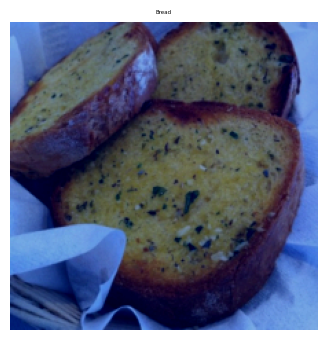

In [12]:
# rearrange the image dimensions
image_permute = image.permute(1,2,0)

# display the image
plt.figure(figsize=(6,4))
plt.imshow(image_permute)
plt.axis("off")
plt.title(train_data.classes[label], fontsize=4)

In [13]:
BATCH_SIZE = 64

# convert dataset to dataloader
train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

val_dataloader = DataLoader(val_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

In [14]:
# get a batch of images and labels from the dataloader
train_images,train_labels = next(iter(train_dataloader))
print(train_images.shape)
print(train_labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


**TRAINING**

In [15]:
# function to calculate accuracy
def accuracy(labels,preds):
    correct = torch.eq(labels,preds).sum().item()
    acc = (correct/len(labels))*100
    return acc

In [16]:
def train(model, dataloader, criterion, optimizer):
    # set the model to training mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (images, labels) in enumerate(dataloader):
        # send data to target device
        images, labels = images.to(device), labels.to(device)

        # pass the data to the model and get model outputs
        logits = model(images)

        # calulate the loss
        loss = criterion(logits, labels)
        train_loss += loss.item()

        # clear the gradients
        optimizer.zero_grad()

        # calculate the gradients
        loss.backward()

        # update the model parameters
        optimizer.step()

        # calculate the accuracy
        train_acc = train_acc+accuracy(labels,torch.argmax(logits,dim=1))

    # calculate the mean loss
    train_loss = train_loss / len(dataloader)

    # calculate the mean accuracy
    train_acc = train_acc / len(dataloader)

    return train_loss,train_acc

In [17]:
def test(model, dataloader, criterion):
    # set the model to evaluation mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (images, labels) in enumerate(dataloader):
            # send data to target device
            images, labels = images.to(device), labels.to(device)

            # pass the data to the model and get model outputs
            logits = model(images)

            # calulate the loss
            loss = criterion(logits, labels)
            test_loss += loss.item()

            # calculate the accuracy
            test_acc = test_acc+accuracy(labels,torch.argmax(logits,dim=1))

    # calculate the mean loss
    test_loss = test_loss / len(dataloader)

    # calculate the mean accuracy
    test_acc = test_acc / len(dataloader)

    return test_loss,test_acc

In [18]:
def evaluate(model, dataloader, class_names):
    # set the model to evaluation mode
    model.eval()

    all_preds = []
    all_labels = []
    all_top5_preds = []

    with torch.inference_mode():
        for batch, (images, labels) in enumerate(dataloader):
            images, labels = images.to(device), labels.to(device)

            # get predictions from the model
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            top5_preds = torch.topk(logits, k=5, dim=1).indices  # Get top 5 predictions

            # accumulate predictions and true labels
            all_preds = all_preds + preds.cpu().tolist()
            all_labels = all_labels + labels.cpu().tolist()
            all_top5_preds = all_top5_preds + top5_preds.cpu().tolist()

    # convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_top5_preds = np.array(all_top5_preds)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # calculate overall accuracy
    overall_accuracy = accuracy_score(all_labels, all_preds)

    # calculate top-5 accuracy
    top5_correct = 0
    for i in range(len(all_labels)):
        if all_labels[i] in all_top5_preds[i]:
            top5_correct += 1
    top5_accuracy = top5_correct / len(all_labels)

    # calculate per-class accuracy
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

    # # Calculate per-class recall
    # per_class_recall = recall_score(all_labels, all_preds, average=None)

    # plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # print metrics
    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Top-5 Accuracy: {top5_accuracy:.4f}")
    print("\nPer-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {per_class_accuracy[i]:.4f}")

    # print("\nPer-Class Recall:")
    # for i, class_name in enumerate(class_names):
    #     print(f"{class_name}: {per_class_recall[i]:.4f}")

In [19]:
# function to plot the loss and accuracy
def plot_curves(results):
    colors = ['b','g','r','y']

    # plot training losses for all models
    plt.figure(figsize=(8, 6))
    for i,(model, losses) in enumerate(results.items()):
        epochs = range(1, len(losses['train_loss']) + 1)
        plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
        plt.plot(epochs, losses['train_loss'], label=f"{model[0]} Optimizer with LR {model[1]}", color=colors[i], linestyle='-', linewidth=2, marker='D', markersize=5)

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

    # plot validation losses for all models
    plt.figure(figsize=(8, 6))
    for i,(model, losses) in enumerate(results.items()):
        epochs = range(1, len(losses['val_loss']) + 1)
        plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
        plt.plot(epochs, losses['val_loss'], label=f"{model[0]} with LR {model[1]}", color=colors[i], linestyle='-', linewidth=2, marker='D', markersize=5)

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

**VGG-16**

In [ ]:
# # get pretrained model weights
# weights = torchvision.models.VGG16_Weights.DEFAULT

# model = torchvision.models.vgg16(weights=weights).to(device)
# print(model)

In [ ]:
# # freeze the convolutional layers of the model
# for param in model.features.parameters():
#     param.requires_grad = False

In [ ]:
# # update the classifier of the model
# # the output size of the layer should be same as the number of classes in the data
# model.classifier = nn.Sequential(
#     nn.Linear(25088,4096),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.5,inplace=False),
#     nn.Linear(4096,4096),
#     nn.ReLU(inplace=True),
#     nn.Dropout(p=0.5,inplace=False),
#     nn.Linear(4096,len(train_data.classes))
# ).to(device)

# print(model)

In [ ]:
# # loss function
# criterion = nn.CrossEntropyLoss()

# # optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 6

# results dictionary
# results = {"train_loss": [],
#             "val_loss": [],
# }
results = {}


Training with Adam optimizer and learning-rate of 0.001



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 111MB/s]


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7382 | train_acc: 56.55% | val_loss: 0.9602 | val_acc: 69.17%
Epoch: 2 | train_loss: 1.0369 | train_acc: 67.80% | val_loss: 0.8588 | val_acc: 71.88%
Epoch: 3 | train_loss: 0.9672 | train_acc: 70.06% | val_loss: 0.8780 | val_acc: 72.46%
Epoch: 4 | train_loss: 0.9682 | train_acc: 71.69% | val_loss: 0.9152 | val_acc: 71.56%
Epoch: 5 | train_loss: 0.9153 | train_acc: 72.59% | val_loss: 0.8522 | val_acc: 75.17%
Epoch: 6 | train_loss: 0.8962 | train_acc: 74.85% | val_loss: 0.8322 | val_acc: 74.13%


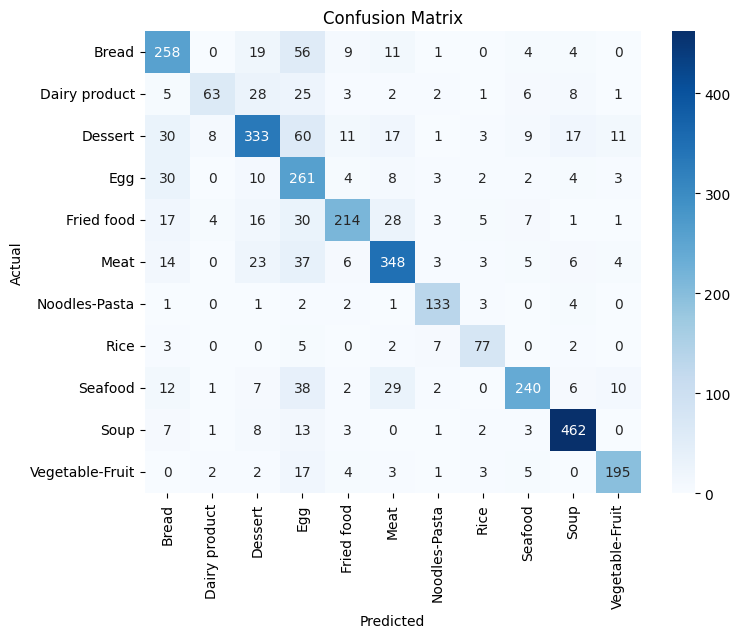

Overall Accuracy: 0.7534
Top-5 Accuracy: 0.9566

Per-Class Accuracy:
Bread: 0.7127
Dairy product: 0.4375
Dessert: 0.6660
Egg: 0.7982
Fried food: 0.6564
Meat: 0.7751
Noodles-Pasta: 0.9048
Rice: 0.8021
Seafood: 0.6916
Soup: 0.9240
Vegetable-Fruit: 0.8405

Training with Adam optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1165 | train_acc: 62.50% | val_loss: 0.9570 | val_acc: 66.97%
Epoch: 2 | train_loss: 0.6774 | train_acc: 77.95% | val_loss: 0.7290 | val_acc: 76.53%
Epoch: 3 | train_loss: 0.5708 | train_acc: 81.65% | val_loss: 0.7280 | val_acc: 77.22%
Epoch: 4 | train_loss: 0.4668 | train_acc: 84.82% | val_loss: 0.7251 | val_acc: 76.94%
Epoch: 5 | train_loss: 0.4229 | train_acc: 86.43% | val_loss: 0.6725 | val_acc: 78.85%
Epoch: 6 | train_loss: 0.3958 | train_acc: 86.99% | val_loss: 0.7095 | val_acc: 78.35%


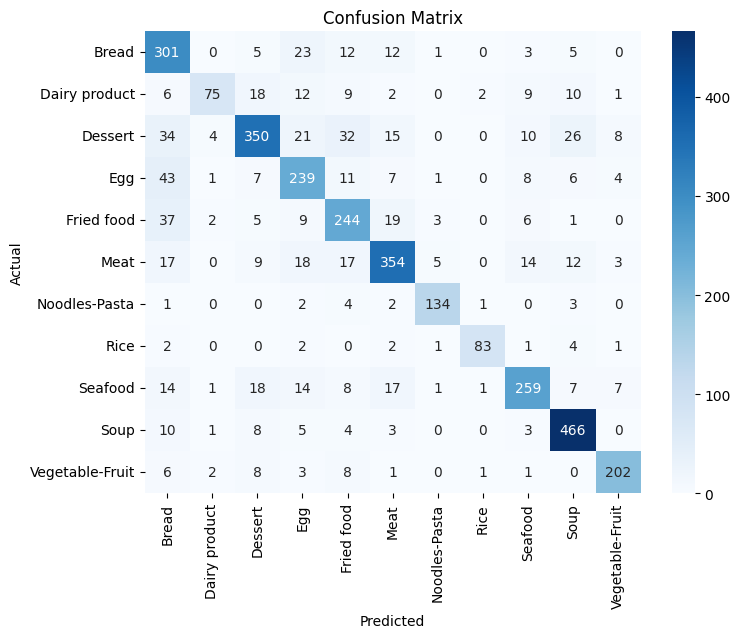

Overall Accuracy: 0.7892
Top-5 Accuracy: 0.9819

Per-Class Accuracy:
Bread: 0.8315
Dairy product: 0.5208
Dessert: 0.7000
Egg: 0.7309
Fried food: 0.7485
Meat: 0.7884
Noodles-Pasta: 0.9116
Rice: 0.8646
Seafood: 0.7464
Soup: 0.9320
Vegetable-Fruit: 0.8707

Training with RMSprop optimizer and learning-rate of 0.001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 32.0244 | train_acc: 39.33% | val_loss: 1.9380 | val_acc: 40.91%
Epoch: 2 | train_loss: 1.4977 | train_acc: 54.22% | val_loss: 1.3512 | val_acc: 54.73%
Epoch: 3 | train_loss: 1.3050 | train_acc: 60.77% | val_loss: 1.3868 | val_acc: 60.24%
Epoch: 4 | train_loss: 1.1603 | train_acc: 64.78% | val_loss: 0.9141 | val_acc: 72.31%
Epoch: 5 | train_loss: 1.0726 | train_acc: 67.78% | val_loss: 0.9510 | val_acc: 73.02%
Epoch: 6 | train_loss: 1.0135 | train_acc: 69.75% | val_loss: 0.9810 | val_acc: 70.96%


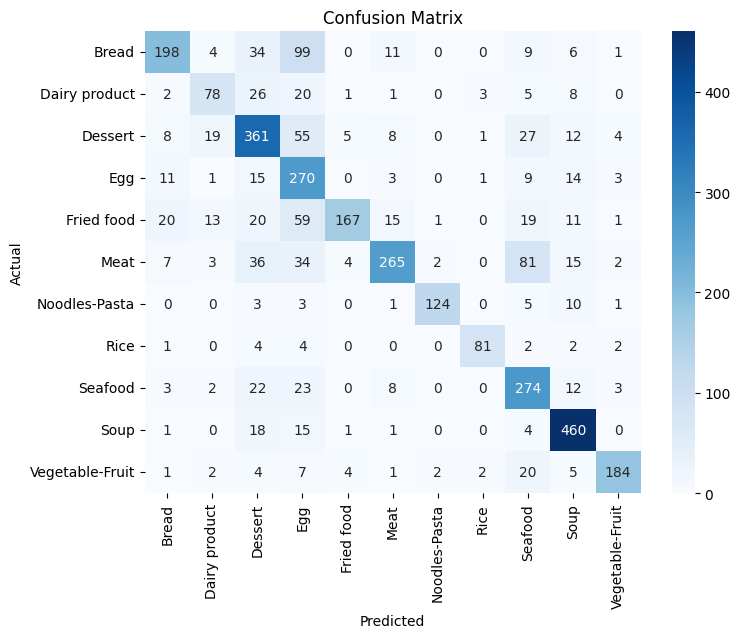

Overall Accuracy: 0.7178
Top-5 Accuracy: 0.9426

Per-Class Accuracy:
Bread: 0.5470
Dairy product: 0.5417
Dessert: 0.7220
Egg: 0.8257
Fried food: 0.5123
Meat: 0.5902
Noodles-Pasta: 0.8435
Rice: 0.8438
Seafood: 0.7896
Soup: 0.9200
Vegetable-Fruit: 0.7931

Training with RMSprop optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3867 | train_acc: 62.83% | val_loss: 0.9942 | val_acc: 69.07%
Epoch: 2 | train_loss: 0.6900 | train_acc: 77.40% | val_loss: 0.7215 | val_acc: 75.11%
Epoch: 3 | train_loss: 0.5650 | train_acc: 81.23% | val_loss: 0.7911 | val_acc: 74.62%
Epoch: 4 | train_loss: 0.4970 | train_acc: 83.83% | val_loss: 0.7202 | val_acc: 77.09%
Epoch: 5 | train_loss: 0.4303 | train_acc: 86.06% | val_loss: 0.8064 | val_acc: 75.82%
Epoch: 6 | train_loss: 0.4044 | train_acc: 86.49% | val_loss: 0.8117 | val_acc: 75.24%


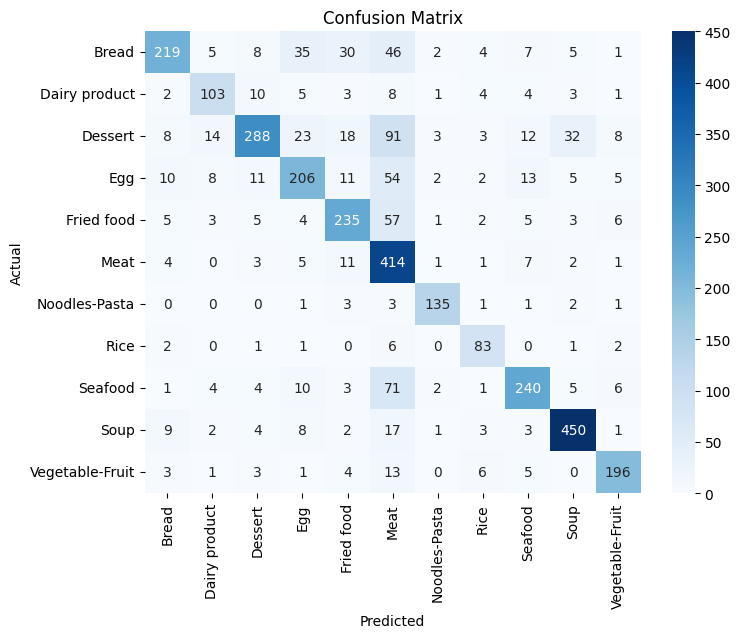

Overall Accuracy: 0.7490
Top-5 Accuracy: 0.9749

Per-Class Accuracy:
Bread: 0.6050
Dairy product: 0.7153
Dessert: 0.5760
Egg: 0.6300
Fried food: 0.7209
Meat: 0.9220
Noodles-Pasta: 0.9184
Rice: 0.8646
Seafood: 0.6916
Soup: 0.9000
Vegetable-Fruit: 0.8448


In [ ]:
for optim in [(torch.optim.Adam,"Adam"),(torch.optim.RMSprop,"RMSprop")]:
    for lr in [0.001,0.0001]:
        print(f"\nTraining with {optim[1]} optimizer and learning-rate of {lr}\n")

        # get pretrained model weights
        weights = torchvision.models.VGG16_Weights.DEFAULT

        # get pretrained model
        model = torchvision.models.vgg16(weights=weights).to(device)

        # freeze the convolutional layers of the model
        for param in model.features.parameters():
            param.requires_grad = False

        # update the classifier of the model
        # the output size of the layer should be same as the number of classes in the data
        model.classifier = nn.Sequential(
            nn.Linear(25088,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5,inplace=False),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5,inplace=False),
            nn.Linear(4096,len(train_data.classes))
        ).to(device)

        # loss function
        criterion = nn.CrossEntropyLoss()

        # optimizer
        optimizer = optim[0](model.parameters(), lr=lr)

        results[(optim[1],lr)] = {
            "train_loss": [],
            "val_loss": []
        }

        for epoch in tqdm(range(epochs)):
            train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
            val_loss,val_acc = test(model,val_dataloader,criterion)

            print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc:.2f}%")

            # update the results dictionary
            results[(optim[1],lr)]["train_loss"].append(train_loss)
            results[(optim[1],lr)]["val_loss"].append(val_loss)

        # evaluate the model on the validation set
        evaluate(model, val_dataloader, class_names)

In [ ]:
# evaluate(model, val_dataloader, class_names)

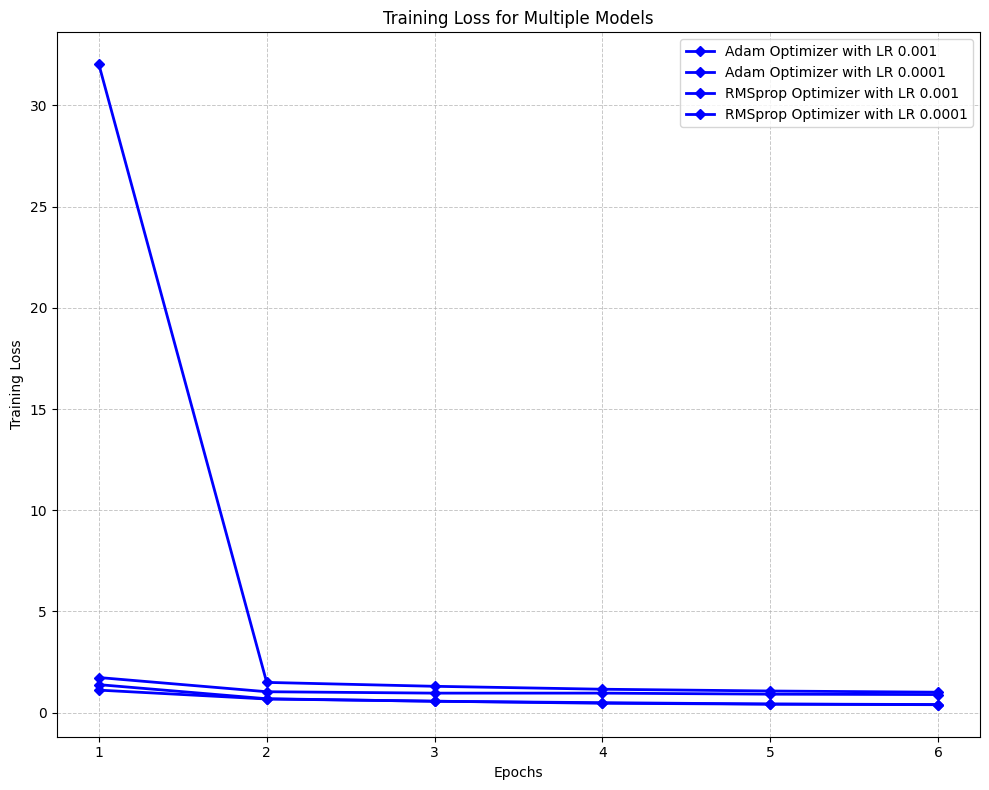

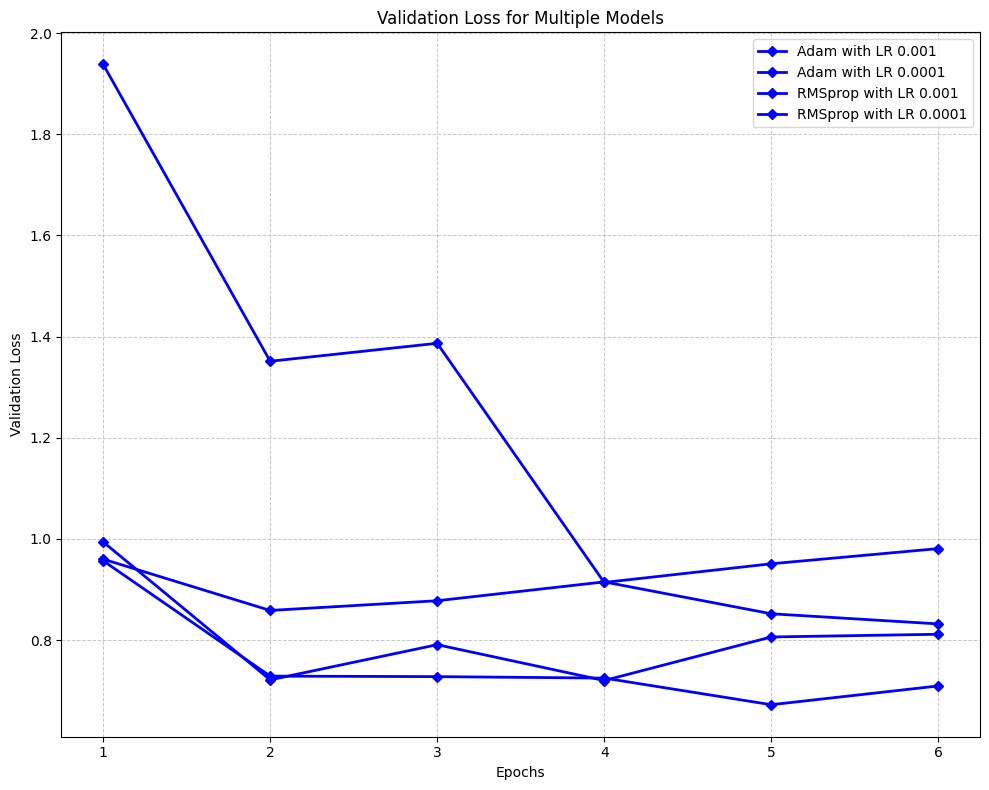

In [ ]:
plot_curves(results)

**RESNET-18**

In [ ]:
# # get pretrained model weights
# weights = torchvision.models.ResNet18_Weights.DEFAULT

# model = torchvision.models.resnet18(weights=weights).to(device)
# print(model)

In [ ]:
# # freeze the convolutional layers of the model
# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
# # update the classifier of the model
# # the output size of the layer should be same as the number of classes in the data
# model.fc = nn.Linear(512,len(train_data.classes)).to(device)

# print(model)

In [ ]:
# # loss function
# criterion = nn.CrossEntropyLoss()

# # optimizer
# optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
epochs = 6

# # results dictionary
# results = {"train_loss": [],
#             "val_loss": [],
# }
results = {}


Training with Adam optimizer and learning-rate of 0.001



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5322 | train_acc: 51.86% | val_loss: 1.1360 | val_acc: 65.01%
Epoch: 2 | train_loss: 1.0176 | train_acc: 67.87% | val_loss: 0.9619 | val_acc: 70.00%
Epoch: 3 | train_loss: 0.9154 | train_acc: 70.00% | val_loss: 0.8900 | val_acc: 71.05%
Epoch: 4 | train_loss: 0.8703 | train_acc: 71.64% | val_loss: 0.8359 | val_acc: 72.52%
Epoch: 5 | train_loss: 0.8212 | train_acc: 73.13% | val_loss: 0.8515 | val_acc: 71.41%
Epoch: 6 | train_loss: 0.8015 | train_acc: 73.61% | val_loss: 0.8674 | val_acc: 71.31%


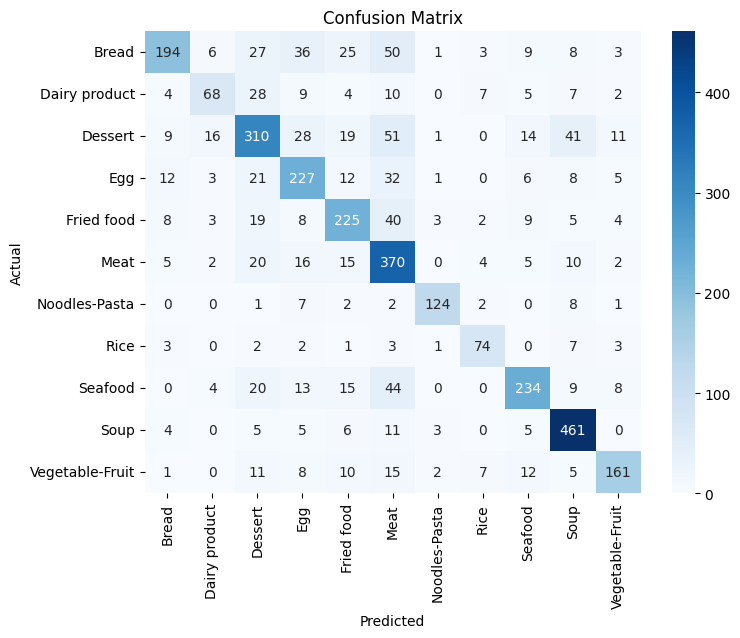

Overall Accuracy: 0.7137
Top-5 Accuracy: 0.9647

Per-Class Accuracy:
Bread: 0.5359
Dairy product: 0.4722
Dessert: 0.6200
Egg: 0.6942
Fried food: 0.6902
Meat: 0.8241
Noodles-Pasta: 0.8435
Rice: 0.7708
Seafood: 0.6744
Soup: 0.9220
Vegetable-Fruit: 0.6940

Training with Adam optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2290 | train_acc: 21.44% | val_loss: 2.0274 | val_acc: 30.90%
Epoch: 2 | train_loss: 1.8677 | train_acc: 38.94% | val_loss: 1.7557 | val_acc: 44.14%
Epoch: 3 | train_loss: 1.6379 | train_acc: 50.42% | val_loss: 1.5618 | val_acc: 53.30%
Epoch: 4 | train_loss: 1.4713 | train_acc: 56.99% | val_loss: 1.4238 | val_acc: 58.36%
Epoch: 5 | train_loss: 1.3573 | train_acc: 60.29% | val_loss: 1.3325 | val_acc: 61.13%
Epoch: 6 | train_loss: 1.2750 | train_acc: 62.50% | val_loss: 1.2581 | val_acc: 62.57%


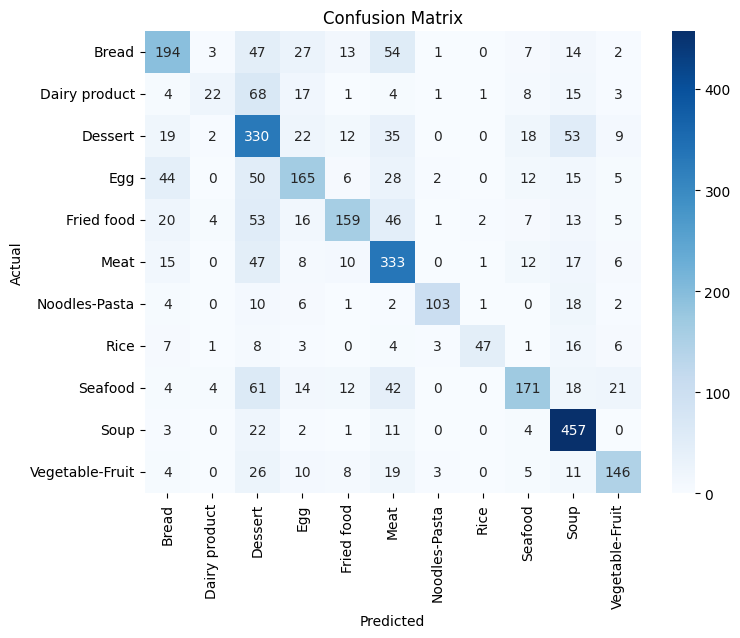

Overall Accuracy: 0.6201
Top-5 Accuracy: 0.9408

Per-Class Accuracy:
Bread: 0.5359
Dairy product: 0.1528
Dessert: 0.6600
Egg: 0.5046
Fried food: 0.4877
Meat: 0.7416
Noodles-Pasta: 0.7007
Rice: 0.4896
Seafood: 0.4928
Soup: 0.9140
Vegetable-Fruit: 0.6293

Training with RMSprop optimizer and learning-rate of 0.001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4139 | train_acc: 55.78% | val_loss: 1.1396 | val_acc: 62.92%
Epoch: 2 | train_loss: 0.9741 | train_acc: 68.52% | val_loss: 1.0160 | val_acc: 66.72%
Epoch: 3 | train_loss: 0.8990 | train_acc: 70.76% | val_loss: 0.9467 | val_acc: 68.27%
Epoch: 4 | train_loss: 0.8547 | train_acc: 71.73% | val_loss: 0.9831 | val_acc: 68.01%
Epoch: 5 | train_loss: 0.8337 | train_acc: 71.91% | val_loss: 1.0238 | val_acc: 65.30%
Epoch: 6 | train_loss: 0.8068 | train_acc: 73.10% | val_loss: 0.9773 | val_acc: 68.10%


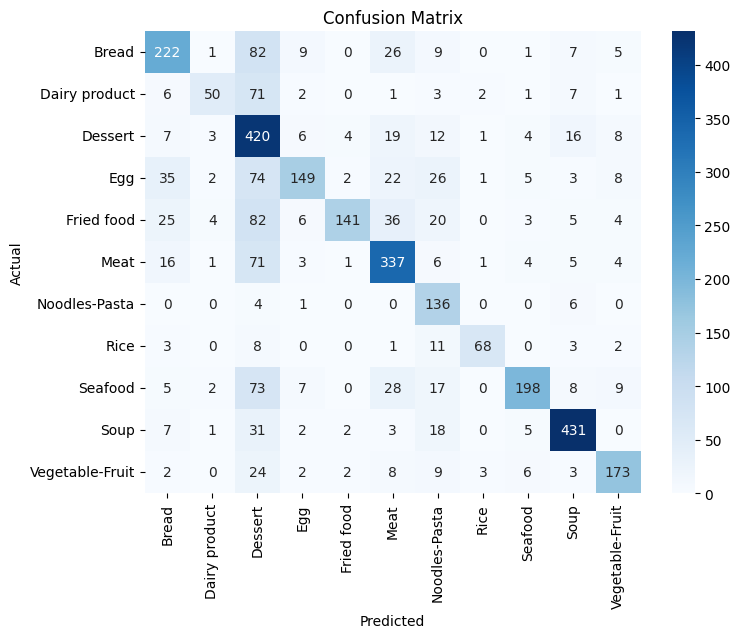

Overall Accuracy: 0.6778
Top-5 Accuracy: 0.9571

Per-Class Accuracy:
Bread: 0.6133
Dairy product: 0.3472
Dessert: 0.8400
Egg: 0.4557
Fried food: 0.4325
Meat: 0.7506
Noodles-Pasta: 0.9252
Rice: 0.7083
Seafood: 0.5706
Soup: 0.8620
Vegetable-Fruit: 0.7457

Training with RMSprop optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9754 | train_acc: 33.67% | val_loss: 1.7768 | val_acc: 45.23%
Epoch: 2 | train_loss: 1.6575 | train_acc: 49.86% | val_loss: 1.5725 | val_acc: 53.69%
Epoch: 3 | train_loss: 1.4738 | train_acc: 56.55% | val_loss: 1.4222 | val_acc: 57.65%
Epoch: 4 | train_loss: 1.3546 | train_acc: 60.61% | val_loss: 1.3096 | val_acc: 62.09%
Epoch: 5 | train_loss: 1.2656 | train_acc: 63.11% | val_loss: 1.2321 | val_acc: 63.48%
Epoch: 6 | train_loss: 1.1986 | train_acc: 64.95% | val_loss: 1.1844 | val_acc: 64.89%


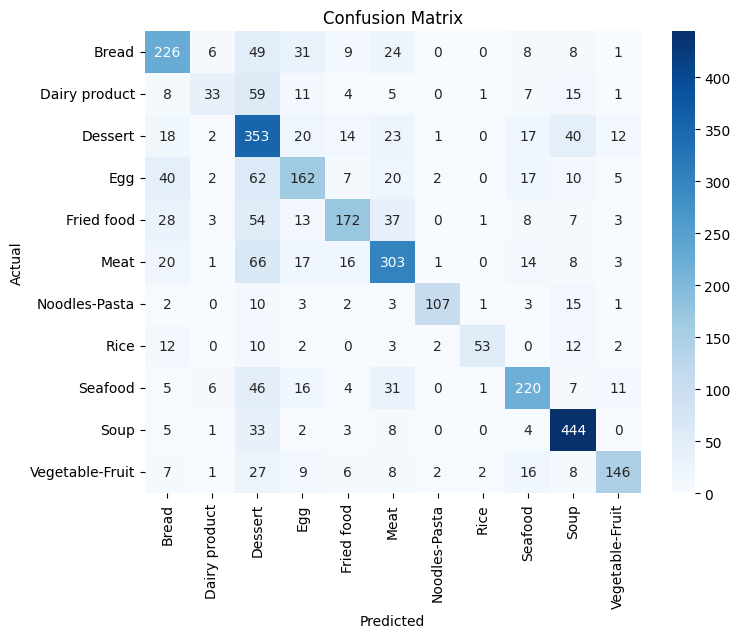

Overall Accuracy: 0.6469
Top-5 Accuracy: 0.9475

Per-Class Accuracy:
Bread: 0.6243
Dairy product: 0.2292
Dessert: 0.7060
Egg: 0.4954
Fried food: 0.5276
Meat: 0.6748
Noodles-Pasta: 0.7279
Rice: 0.5521
Seafood: 0.6340
Soup: 0.8880
Vegetable-Fruit: 0.6293


In [ ]:
for optim in [(torch.optim.Adam,"Adam"),(torch.optim.RMSprop,"RMSprop")]:
    for lr in [0.001,0.0001]:
        print(f"\nTraining with {optim[1]} optimizer and learning-rate of {lr}\n")

        # get pretrained model weights
        weights = torchvision.models.ResNet18_Weights.DEFAULT

        # get pretrained model
        model = torchvision.models.resnet18(weights=weights).to(device)

        # freeze the convolutional layers of the model
        for param in model.parameters():
            param.requires_grad = False

        # update the classifier of the model
        # the output size of the layer should be same as the number of classes in the data
        model.fc = nn.Linear(512,len(train_data.classes)).to(device)

        # loss function
        criterion = nn.CrossEntropyLoss()

        # optimizer
        optimizer = optim[0](model.parameters(), lr=lr)

        results[(optim[1],lr)] = {
            "train_loss": [],
            "val_loss": []
        }

        for epoch in tqdm(range(epochs)):
            train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
            val_loss,val_acc = test(model,val_dataloader,criterion)

            print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc:.2f}%")

            # update the results dictionary
            results[(optim[1],lr)]["train_loss"].append(train_loss)
            results[(optim[1],lr)]["val_loss"].append(val_loss)

        # evaluate the model on the validation set
        evaluate(model, val_dataloader, class_names)

In [ ]:
# evaluate(model, val_dataloader, class_names)

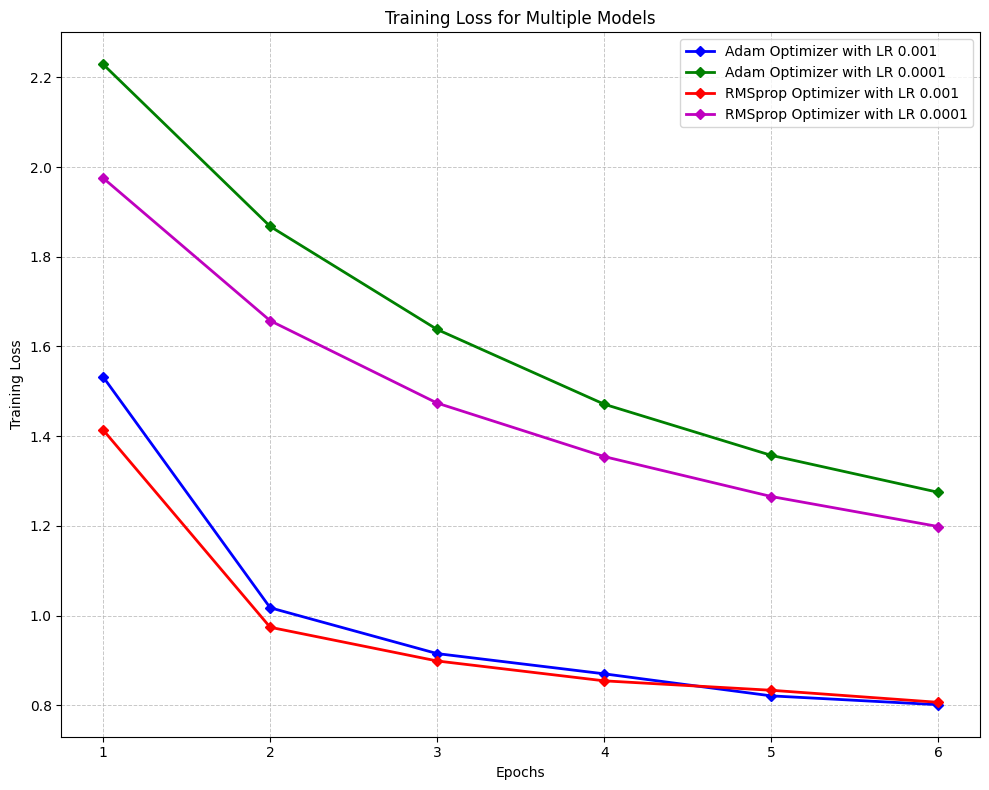

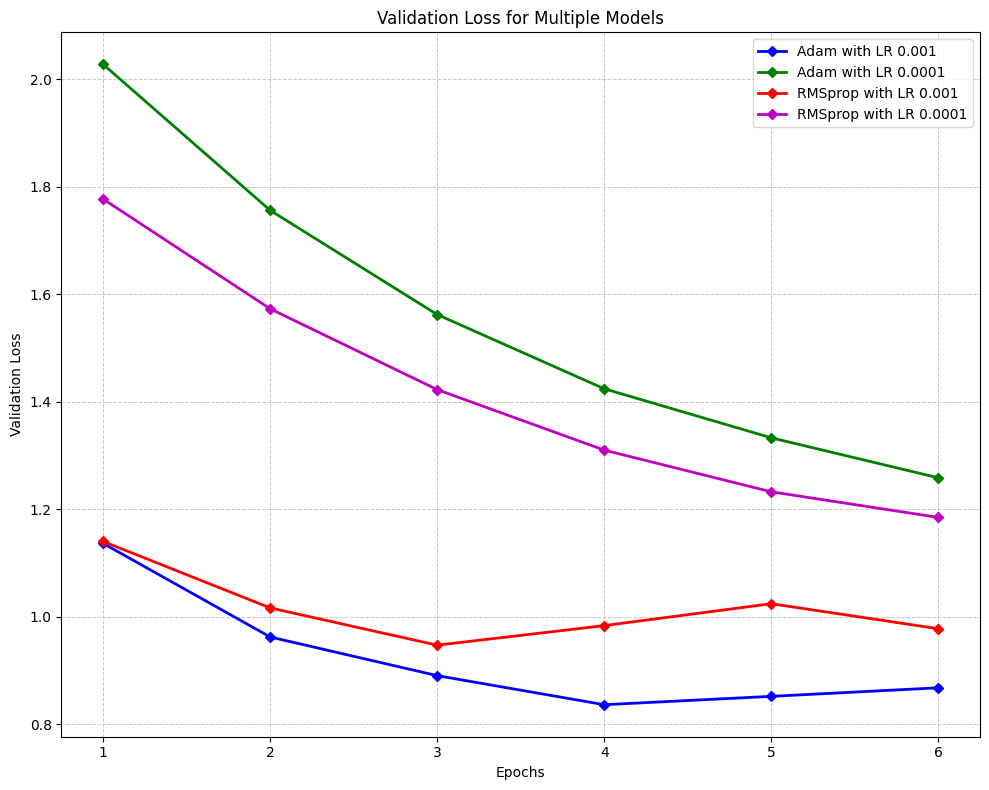

In [ ]:
plot_curves(results)

**VISION TRANSFORMER**

In [20]:
# # get pretrained model weights
# weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# model = torchvision.models.vit_b_16(weights=weights).to(device)
# print(model)

In [21]:
# # freeze the convolutional layers of the model
# for param in model.encoder.parameters():
#     param.requires_grad = False

In [22]:
# # update the classifier of the model
# # the output size of the layer should be same as the number of classes in the data
# model.heads = nn.Sequential(
#     nn.Linear(768,len(train_data.classes))
# ).to(device)

# print(model)

In [23]:
# # loss function
# criterion = nn.CrossEntropyLoss()

# # optimizer
# optimizer = torch.optim.Adam(model.parameters(),lr=0.0004)

In [24]:
epochs = 6

# # results dictionary
# results = {"train_loss": [],
#             "val_loss": [],
# }
results = {}


Training with Adam optimizer and learning-rate of 0.001



Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 64.6MB/s]


  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1483 | train_acc: 22.66% | val_loss: 2.0408 | val_acc: 27.42%
Epoch: 2 | train_loss: 2.0243 | train_acc: 28.34% | val_loss: 1.9918 | val_acc: 29.50%
Epoch: 3 | train_loss: 1.9646 | train_acc: 30.79% | val_loss: 2.0001 | val_acc: 29.80%
Epoch: 4 | train_loss: 1.9050 | train_acc: 33.27% | val_loss: 1.8284 | val_acc: 36.26%
Epoch: 5 | train_loss: 1.8759 | train_acc: 34.71% | val_loss: 1.9351 | val_acc: 33.84%
Epoch: 6 | train_loss: 1.8266 | train_acc: 36.25% | val_loss: 1.8521 | val_acc: 35.22%


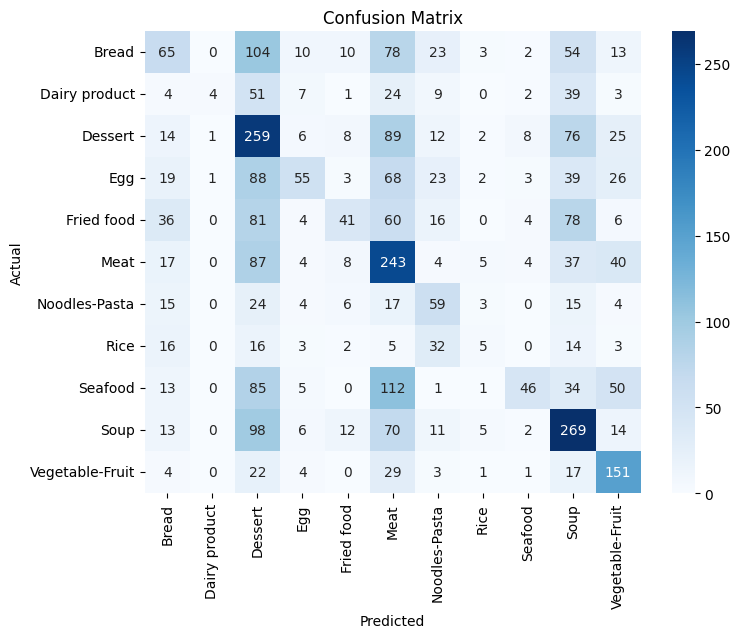

Overall Accuracy: 0.3490
Top-5 Accuracy: 0.8341

Per-Class Accuracy:
Bread: 0.1796
Dairy product: 0.0278
Dessert: 0.5180
Egg: 0.1682
Fried food: 0.1258
Meat: 0.5412
Noodles-Pasta: 0.4014
Rice: 0.0521
Seafood: 0.1326
Soup: 0.5380
Vegetable-Fruit: 0.6509

Training with Adam optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7812 | train_acc: 47.00% | val_loss: 1.3968 | val_acc: 61.56%
Epoch: 2 | train_loss: 1.1731 | train_acc: 68.75% | val_loss: 1.0480 | val_acc: 70.13%
Epoch: 3 | train_loss: 0.9085 | train_acc: 74.72% | val_loss: 0.8814 | val_acc: 74.74%
Epoch: 4 | train_loss: 0.7708 | train_acc: 78.10% | val_loss: 0.7833 | val_acc: 76.89%
Epoch: 5 | train_loss: 0.6993 | train_acc: 79.74% | val_loss: 0.7314 | val_acc: 77.55%
Epoch: 6 | train_loss: 0.6467 | train_acc: 81.06% | val_loss: 0.7187 | val_acc: 77.53%


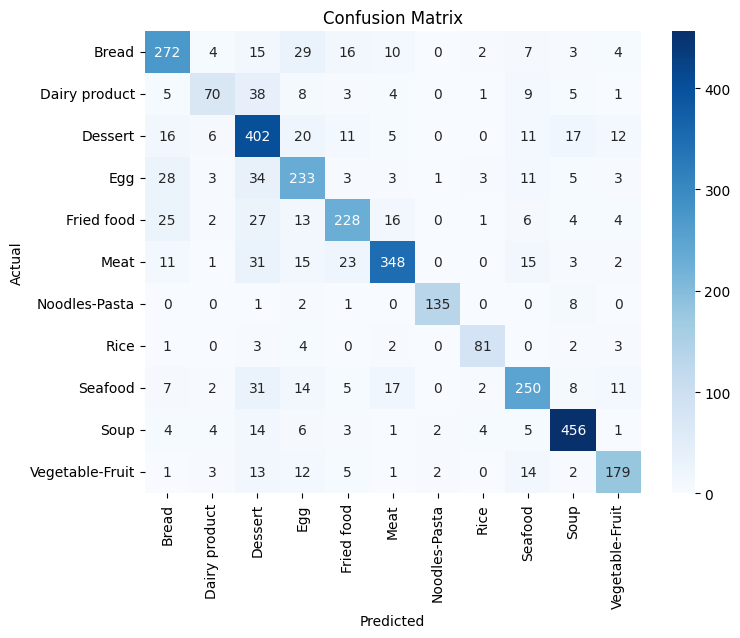

Overall Accuracy: 0.7738
Top-5 Accuracy: 0.9773

Per-Class Accuracy:
Bread: 0.7514
Dairy product: 0.4861
Dessert: 0.8040
Egg: 0.7125
Fried food: 0.6994
Meat: 0.7751
Noodles-Pasta: 0.9184
Rice: 0.8438
Seafood: 0.7205
Soup: 0.9120
Vegetable-Fruit: 0.7716

Training with RMSprop optimizer and learning-rate of 0.001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.3050 | train_acc: 17.90% | val_loss: 2.5443 | val_acc: 14.35%
Epoch: 2 | train_loss: 2.1758 | train_acc: 22.08% | val_loss: 2.4951 | val_acc: 17.09%
Epoch: 3 | train_loss: 2.1171 | train_acc: 24.12% | val_loss: 2.3656 | val_acc: 21.42%
Epoch: 4 | train_loss: 2.0749 | train_acc: 25.82% | val_loss: 2.2204 | val_acc: 20.33%
Epoch: 5 | train_loss: 2.0413 | train_acc: 27.08% | val_loss: 2.0974 | val_acc: 26.05%
Epoch: 6 | train_loss: 2.0146 | train_acc: 28.30% | val_loss: 2.1933 | val_acc: 22.89%


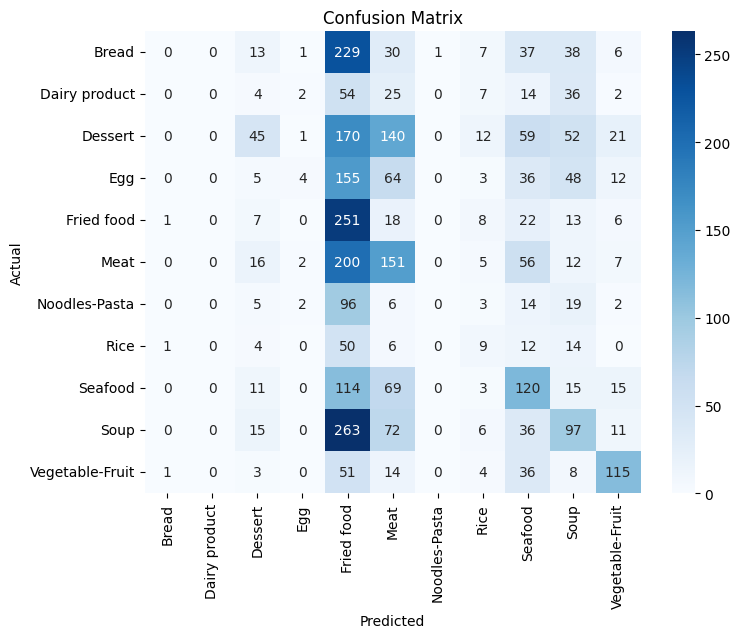

Overall Accuracy: 0.2309
Top-5 Accuracy: 0.7408

Per-Class Accuracy:
Bread: 0.0000
Dairy product: 0.0000
Dessert: 0.0900
Egg: 0.0122
Fried food: 0.7699
Meat: 0.3363
Noodles-Pasta: 0.0000
Rice: 0.0938
Seafood: 0.3458
Soup: 0.1940
Vegetable-Fruit: 0.4957

Training with RMSprop optimizer and learning-rate of 0.0001



  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7497 | train_acc: 44.27% | val_loss: 1.5152 | val_acc: 53.16%
Epoch: 2 | train_loss: 1.1655 | train_acc: 66.75% | val_loss: 1.1009 | val_acc: 66.41%
Epoch: 3 | train_loss: 0.9040 | train_acc: 73.91% | val_loss: 0.9193 | val_acc: 72.10%
Epoch: 4 | train_loss: 0.7657 | train_acc: 77.58% | val_loss: 0.7858 | val_acc: 76.26%
Epoch: 5 | train_loss: 0.6868 | train_acc: 79.65% | val_loss: 0.7330 | val_acc: 77.33%
Epoch: 6 | train_loss: 0.6272 | train_acc: 80.88% | val_loss: 0.7585 | val_acc: 75.85%


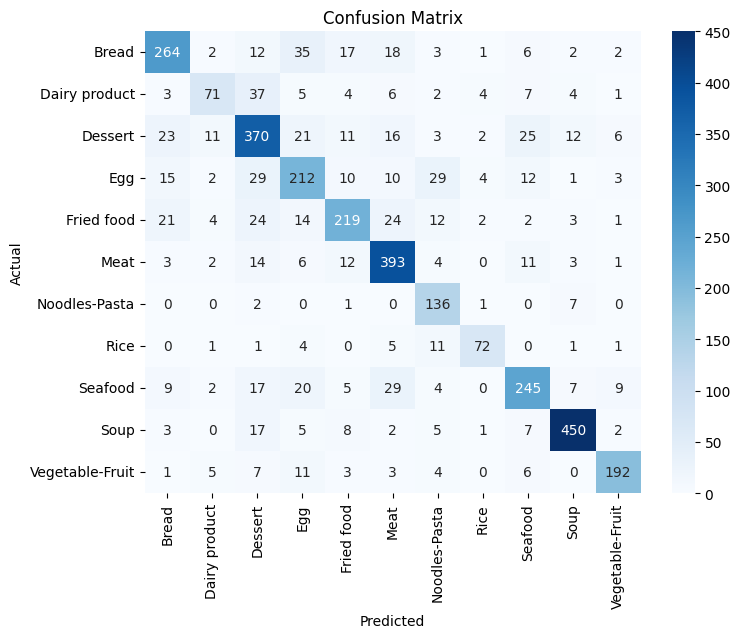

Overall Accuracy: 0.7650
Top-5 Accuracy: 0.9767

Per-Class Accuracy:
Bread: 0.7293
Dairy product: 0.4931
Dessert: 0.7400
Egg: 0.6483
Fried food: 0.6718
Meat: 0.8753
Noodles-Pasta: 0.9252
Rice: 0.7500
Seafood: 0.7061
Soup: 0.9000
Vegetable-Fruit: 0.8276


In [25]:
for optim in [(torch.optim.Adam,"Adam"),(torch.optim.RMSprop,"RMSprop")]:
    for lr in [0.001,0.0001]:
        print(f"\nTraining with {optim[1]} optimizer and learning-rate of {lr}\n")

        # get pretrained model weights
        weights = torchvision.models.ViT_B_16_Weights.DEFAULT

        # get pretrained model
        model = torchvision.models.vit_b_16(weights=weights).to(device)

        # freeze the convolutional layers of the model
        for param in model.encoder.parameters():
            param.requires_grad = False

        # update the classifier of the model
        # the output size of the layer should be same as the number of classes in the data
        model.heads = nn.Sequential(
            nn.Linear(768,len(train_data.classes))
        ).to(device)

        # loss function
        criterion = nn.CrossEntropyLoss()

        # optimizer
        optimizer = optim[0](model.parameters(), lr=lr)

        results[(optim[1],lr)] = {
            "train_loss": [],
            "val_loss": []
        }

        for epoch in tqdm(range(epochs)):
            train_loss,train_acc = train(model,train_dataloader,criterion,optimizer)
            val_loss,val_acc = test(model,val_dataloader,criterion)

            print(f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f}% | val_loss: {val_loss:.4f} | val_acc: {val_acc:.2f}%")

            # update the results dictionary
            results[(optim[1],lr)]["train_loss"].append(train_loss)
            results[(optim[1],lr)]["val_loss"].append(val_loss)

        # evaluate the model on the validation set
        evaluate(model, val_dataloader, class_names)

In [26]:
# evaluate(model, val_dataloader, class_names)

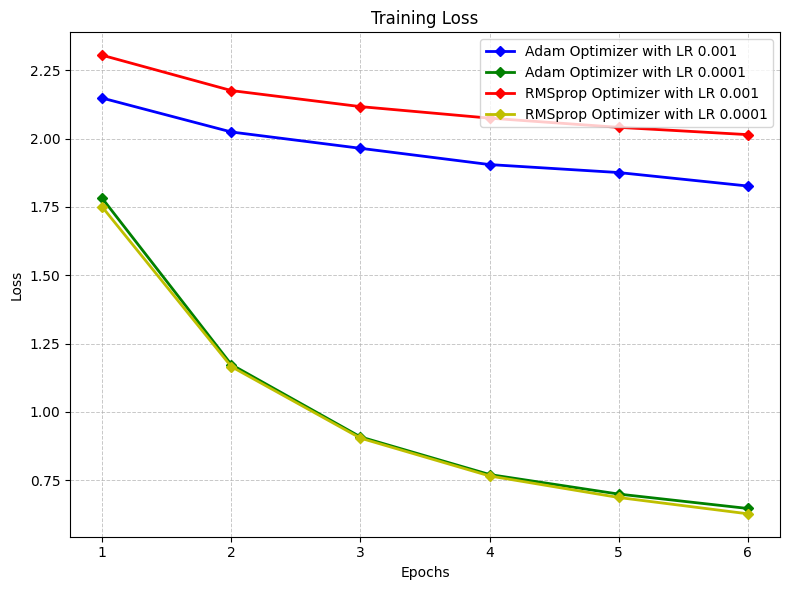

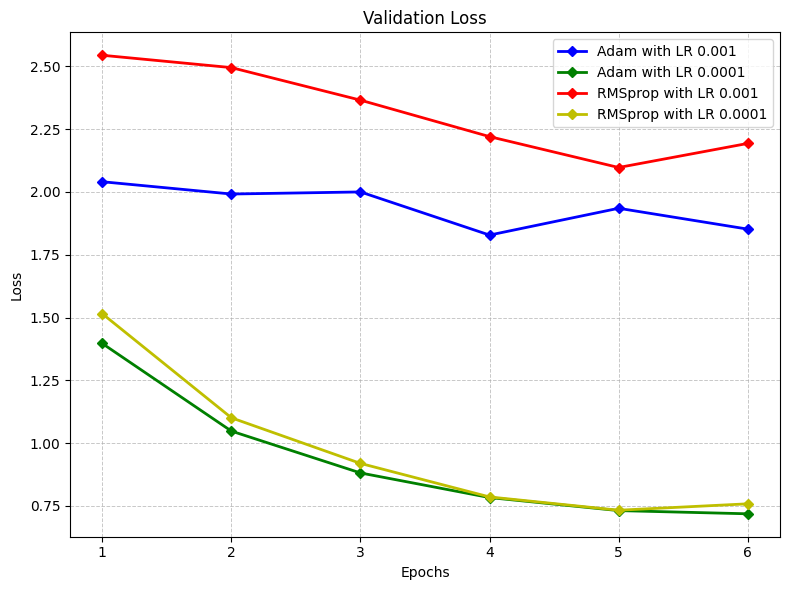

In [27]:
plot_curves(results)